In [1]:
import numpy as np
import scipy.stats
import scipy.ndimage
import pandas
import matplotlib.pyplot as plt
import matplotlib.patches
import numbers
import imageio.v2 as imageio
from IPython.display import clear_output

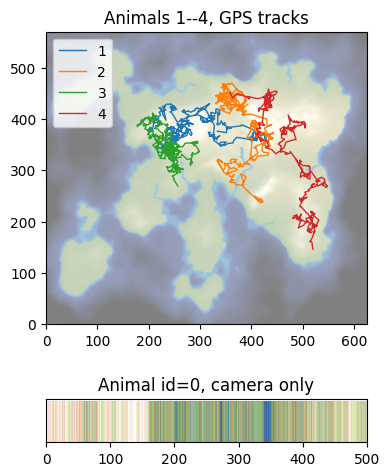

In [12]:
## Data Import
map_image = imageio.imread('island.png')
localization = pandas.read_csv('localization.csv')
localization.sort_values(['id','t'], inplace=True)

# Pull out observations for the animal we want to track
observations = localization.loc[localization.id==0, ['r','g','b']].values

df = localization
NUMANIMALS = 5
EPSILON = np.finfo(np.float32).eps

fig,(ax,ax2) = plt.subplots(2,1, figsize=(4,5), gridspec_kw={'height_ratios':[4,.5]})
ax.imshow(map_image, origin='lower', alpha=.5)
H,W = map_image.shape[:2]
ax.set_xlim([0,W])
ax.set_ylim([0,H])

for i in range(1, NUMANIMALS):
    ax.plot(df.loc[df.id==i,'x'].values, df.loc[df.id==i,'y'].values, lw=1, label=i)
ax.legend()
ax.set_title('Animals 1--4, GPS tracks')

ax2.bar(np.arange(len(observations)), np.ones(len(observations)), color=observations, width=2)
ax2.set_xlim([0,len(observations)])
ax2.set_yticks([])
ax2.set_title('Animal id=0, camera only')

plt.tight_layout()
plt.show()

In [3]:
def GetAtAvg(xy, size=3):
    s = (size-1) / 2
    nx,ny = np.meshgrid(np.arange(-s,s+1), np.arange(-s,s+1))
    nx,ny = np.stack([nx,ny], axis=0).reshape((2,-1))
    neighbourhood = np.row_stack([nx,ny])    
    neighbours = neighbourhood + np.array(xy).reshape(-1,1)
    neighbours = nx,ny = np.round(neighbours).astype(int)
    nx,ny = neighbours[:, (nx>=0) & (nx<W) & (ny>=0) & (ny<H)]
    patch = map_image[ny,nx,:3] 
    return np.mean(patch, axis=0)/255
    
def GetAt(xy):
    nx,ny = np.floor(xy).astype(int)
    pixel = map_image[ny,nx,:3] 
    return pixel/255

def ShowParticles(particles, ax=None, s=1, c='red', alpha=.5, weighted=True):
    # Plot an array of particles, with size proportional to weight
    if ax is None:
        fig,ax = plt.subplots(figsize=(2.5,2.5))
    ax.imshow(map_image, origin='lower', alpha=alpha)
    ax.set_xlim([0,W])
    ax.set_ylim([0,H])
    w = particles[:,2]
    if (weighted):
        ax.scatter(particles[:,0],particles[:,1], s=w/np.sum(w)*s, color=c)
    else:
        ax.scatter(particles[:,0],particles[:,1], s=s, color=c)
    ax.axis('off')

Exact SD: 0.03587393204059611
Avg SD: 0.03384207213800687
SD: 0.03587393204059611


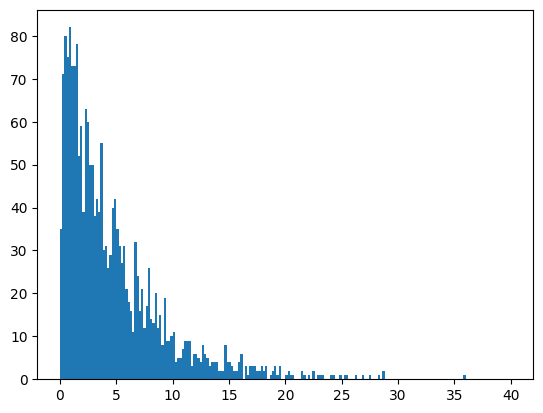

Step Distance Mean: 4.680114079068984
Theta: 0.21367000528306143


In [4]:
## We will model the camera as producing colors with some normal distribution of error,
## here we calculate the SD based on the observations of other animals

distancesExact = np.empty(shape=(0))
distancesAvg = np.empty(shape=(0))
for i in range (1, NUMANIMALS):
    locs = np.column_stack((df.loc[df.id==i,'x'].values, df.loc[df.id==i,'y'].values))
    seenCols = localization.loc[localization.id==i, ['r','g','b']].values
    colErrorExact = np.array([seenCols[i] - GetAt(locs[i]) for i in range(0, len(locs))])
    colErrorAvg = np.array([seenCols[i] - GetAtAvg(locs[i], size=3) for i in range(0, len(locs))])
    distancesExact = np.concatenate((distancesExact, np.linalg.norm(colErrorExact, axis=1)))
    distancesAvg = np.concatenate((distancesAvg, np.linalg.norm(colErrorAvg, axis=1)))
    
exactSD = np.std(distancesExact) 
avgSD = np.std(distancesAvg) 
cameraErrorSD = exactSD
print(f"Exact SD: {exactSD}")
print(f"Avg SD: {avgSD}")
print(f"SD: {cameraErrorSD}")

## We will model the animals as in a random direction (uniform 0,2pi) with a random distance,
## first we plot the distances on a histogram to figure out an appropirate distribtuion to fit
steps = np.empty(shape=(0,2))
for i in range (1, NUMANIMALS):
    currentLocs = np.column_stack((df.loc[df.id==i,'x'].values, df.loc[df.id==i,'y'].values))
    steps = np.concatenate((steps, currentLocs[1:] - currentLocs[:-1]))
    
stepDistances = np.linalg.norm(steps, axis=1)  

## From the histogram we see an exponential distribution seems decent
plt.hist(stepDistances, bins=200, range=[0, 40])
plt.show() 
print(f"Step Distance Mean: {np.mean(stepDistances)}")

## Calculate the arg for an exponential distribution
theta = 1/np.mean(stepDistances)
print(f"Theta: {theta}")

In [5]:
## Change to use HSL in future?
def pr(y, loc):
    val = scipy.stats.norm.pdf(np.linalg.norm(y-GetAt(loc)),0,cameraErrorSD)
    return val
    
def walk(loc):
    stepDir = np.random.uniform(0,2*np.pi)
    dist = np.random.exponential(1/theta)
    newLoc = loc + (dist*np.cos(stepDir), dist*np.sin(stepDir))
    return np.clip(newLoc, 0, [W-EPSILON,H-EPSILON])

In [6]:
## Get initial distribution
numParticles = 3000
x0src = np.column_stack([np.random.uniform(0,W-1,size=numParticles), np.random.uniform(0,H-1,size=numParticles), np.ones(numParticles)/numParticles])

## Sanity checks
y0 = observations[0]
loc = x0src[0,:2]
w = pr(y0, loc)
print(f"Pr(y={y0}) = {w}")
assert isinstance(w, numbers.Number) and w>=0

loc = x0src[0,:2]
loc2 = walk(loc)
print(f"Walk: {loc} to {loc2}")
assert len(loc2)==2 and isinstance(loc2[0], numbers.Number) and isinstance(loc2[1], numbers.Number)
assert loc2[0]>=0 and loc2[0]<=W-1 and loc2[1]>=0 and loc2[1]<=H-1

loc = x0src[0,:2]  
y0 = observations[0]
col = GetAtAvg(loc, size=3)
print(f"First particle is at {loc}")
print(f"First observation: rgb = {y0}")
print(f"Map terrain around this particle: mean rgb = {col}")

Pr(y=[0.93358301 0.87008766 0.85201094]) = 2.5363789640330466e-108
Walk: [ 65.00087651 229.1644784 ] to [ 64.57947942 225.48915925]
First particle is at [ 65.00087651 229.1644784 ]
First observation: rgb = [0.93358301 0.87008766 0.85201094]
Map terrain around this particle: mean rgb = [0.21742919 0.5124183  0.70893246]


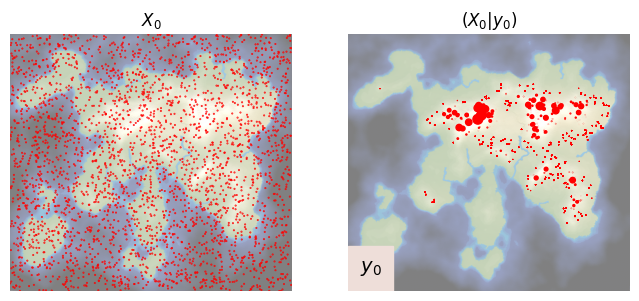

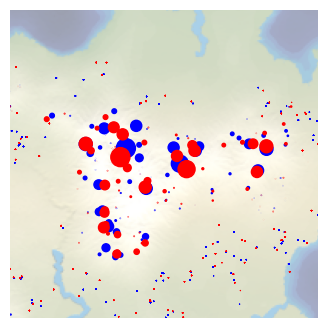

In [7]:
## Show some example walks
y0 = observations[0]
w = np.array([pr(y0, (x,y)) for x,y,_ in x0src])
x0 = np.copy(x0src)
x0[:,2] = w / np.sum(w)

fig,(ax1,ax2) = plt.subplots(1,2, figsize=(8,4), sharex=True, sharey=True)
ShowParticles(x0src, ax=ax1, s=600)
ShowParticles(x0, ax=ax2, s=600)
ax2.add_patch(matplotlib.patches.Rectangle((0,0),100,100,color=y0))
ax2.text(50,50,'$y_0$', c='black', ha='center', va='center', fontsize=14)
ax1.set_title('$X_0$')
ax2.set_title('$(X_0|y_0)$')
plt.show()

x1 = np.copy(x0)
for i in range(len(x1)):
    x1[i,:2] = walk(x1[i,:2])
    
fig,ax = plt.subplots(figsize=(4,4))
ShowParticles(x0, ax=ax, s=4000, c='blue', alpha=.25)
ShowParticles(x1, ax=ax, s=4000, c='red', alpha=.25)
ax.set_xlim([350,550])
ax.set_ylim([300,500])
plt.show()

In [63]:
## Gets rid of bottom 20%
def PruneBasic(particles):
    # Can't do everything in place unfortunately
    sParticles = particles[particles[:, 2].argsort()]
    # Clear lowest 20% of particles
    pruneCount = len(sParticles) // 5
    for i in range(pruneCount):
        sParticles[len(sParticles)-i-1,2] *= 0.5
        sParticles[i] = sParticles[len(sParticles)-i-1]
    return sParticles

## Sequential importance resampling
def PruneSIR(particles):
    i = np.random.choice(len(particles), len(particles), p=particles[:,2])
    rwParticles = particles[i]
    rwParticles[:,2] = 1/len(particles)
    return rwParticles

## Run this if you want to see distribution of weights over timesteps, change PRUNE mode to whatever you desire
def TimedParticleDistributions():
    fig,axes = plt.subplots(5,1, figsize=(8,6), sharey=True)
    curIter = 0    
    particles = np.copy(x0)    
    
    for n,ax in zip([0,1,5,50,100],axes):
        while (curIter < n):
            particles = PruneBasic(particles)
            for i in range(num_particles):
                particles[i,:2] = walk(particles[i,:2])
            w = particles[:,2]
            w *= np.array([pr(observations[n], (px,py)) for px,py,_ in particles])
            particles[:,2] = w / np.sum(w)
            curIter += 1
        
        ax.hist(particles[:,2], bins=60)
        ax.axvline(x=1/len(particles), color='black', linewidth=4, linestyle='dashed')
        ax.set_title(f"timestep {n}", y=0.6)
        
    plt.tight_layout()
    plt.show()


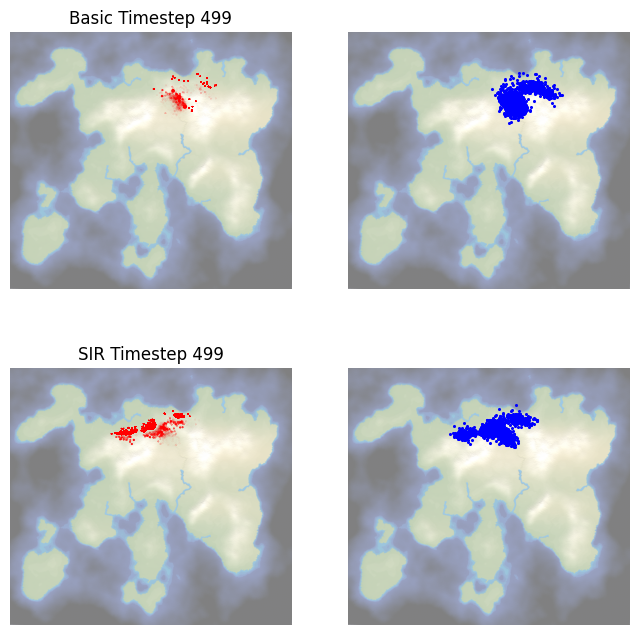

In [9]:
## Final calculation of stoats location
particlesB = np.copy(x0)
particlesSIR = np.copy(x0)
for n,obs in enumerate(observations[1:]):
    # Prune/spawn
    particlesB = PruneBasic(particlesB)
    particlesSIR = PruneSIR(particlesSIR)
    # Compute the locations after a movement step
    for i in range(numParticles):
        particlesB[i,:2] = walk(particlesB[i,:2])
        particlesSIR[i,:2] = walk(particlesSIR[i,:2])
        
    # Compute the posterior after observing y
    w = particlesB[:,2]
    w *= np.array([pr(obs, (px,py)) for px,py,_ in particlesB])
    particlesB[:,2] = w / np.sum(w)       
    w = particlesSIR[:,2]
    w *= np.array([pr(obs, (px,py)) for px,py,_ in particlesSIR])
    particlesSIR[:,2] = w / np.sum(w) 

    # Plots
    fig,ax = plt.subplots(2, 2, figsize=(8,8), sharex=True, sharey=True)
    # Plot the weighted particles
    ShowParticles(particlesB, ax[0,0], s=20)
    ShowParticles(particlesB[particlesB[:,2] > 0], ax[0,1], s=1.5, c='blue', weighted=False)
    ShowParticles(particlesSIR, ax[1,0], s=20)
    ShowParticles(particlesSIR[particlesSIR[:,2] > 0], ax[1,1], s=1.5, c='blue', weighted=False)
    ax[0,0].set_title(f"Basic Timestep {n+1}")
    ax[1,0].set_title(f"SIR Timestep {n+1}")
    plt.show()
    clear_output(wait=True)

Sigma x:4, y:4


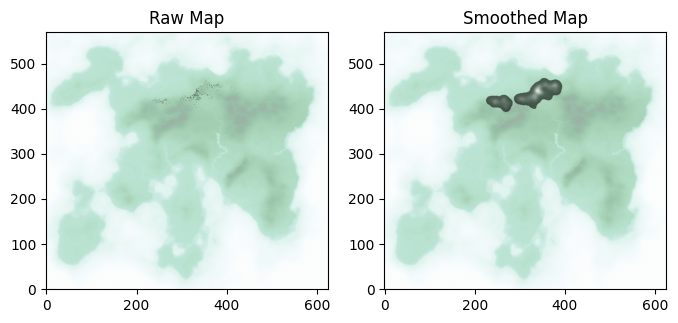

In [64]:
def AddAt(im, particle):
    nx,ny = np.floor(particle[:2]).astype(int)
    im[ny,nx] += particle[2]
    
p = np.zeros(shape=(H,W))
[AddAt(p, particlesSIR[i]) for i in range(len(particlesSIR))]

assert np.sum(p) == 1
assert p.shape == map_image.shape[:2]
assert np.all(p >= 0)

## We apply a gaussian blur ot our probabilities, with somewhat arbitrary values
sigmaX = 4 #np.std(particlesSIR[:,0])
sigmaY = 4 #np.std(particlesSIR[:,1])
print(f"Sigma x:{sigmaX}, y:{sigmaY}")
smoothedP = scipy.ndimage.gaussian_filter(p, sigma=[sigmaY,sigmaX])

plt.imsave("stoat_prediction.png", p, cmap='gray', vmin=0)
plt.imsave("stoat_prediction_smoothed.png", smoothedP, cmap='gray', vmin=0)

predImage = imageio.imread('stoat_prediction.png')
predImage[:,:,-1] = np.where(predImage[:,:,0]>0, 255, 0)
predImageSmooth = imageio.imread('stoat_prediction_smoothed.png')
predImageSmooth[:,:,-1] = np.where(predImageSmooth[:,:,0]>0, 255, 0)

fig,(ax1,ax2) = plt.subplots(1, 2, figsize=(8,4))
ax1.imshow(np.mean(map_image,-1), origin='lower', alpha=.4, cmap='BuGn')
ax2.imshow(np.mean(map_image,-1), origin='lower', alpha=.4, cmap='BuGn')
ax1.imshow(predImage, origin='lower', alpha=.6)
ax2.imshow(predImageSmooth, origin='lower', alpha=.6)   
ax1.set_title("Raw Map")
ax2.set_title("Smoothed Map")
plt.show()